<a href="https://colab.research.google.com/github/mittshah2/Music-Genre-Classification/blob/main/music_classif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import librosa,librosa.display
import matplotlib.pyplot as plt
import numpy as np
import math
import json
import tensorflow as tf
import sklearn
from tqdm import tqdm
import shutil

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
SAMPLE_RATE=22050
DURATION=30
num_segment=6
hop_length=512
n_fft=2048
n_mfcc=15
sample_per_segment=int((SAMPLE_RATE*DURATION)/num_segment)
expected_mfcc_vector_per_segment=math.ceil(sample_per_segment/hop_length)

In [17]:
audio_path='/content/drive/My Drive/audio classification/Data/genres_original/blues/blues.00000.wav'

In [18]:
signal,sr=librosa.load(audio_path,sr=22050) #length of signal=time_of_audio*sr

In [19]:
signal.shape

(661794,)

Text(0, 0.5, 'amplitude')

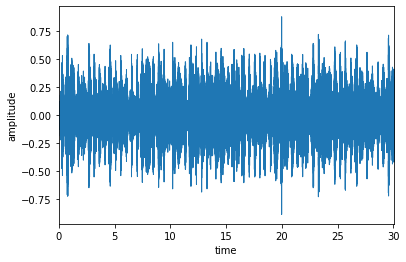

In [20]:
librosa.display.waveplot(signal,sr=sr)
plt.xlabel('time')
plt.ylabel('amplitude')

In [21]:
fft=np.fft.fft(signal)
fft.shape

(661794,)

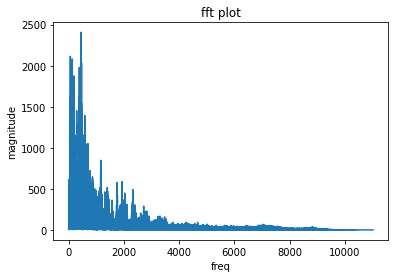

In [22]:
magnitude=np.abs(fft)
freq=np.linspace(0,sr,len(magnitude))
freq=freq[:int(len(freq)/2)]
magnitude=magnitude[:int(len(magnitude)/2)]
plt.xlabel('freq')
plt.ylabel('magnitude')
plt.title('fft plot')
plt.plot(freq,magnitude)

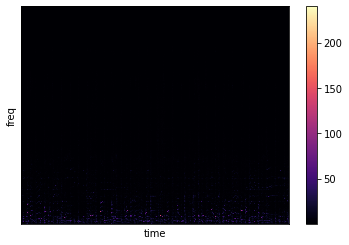

In [23]:
n_fft=2048      #frame size
hop_length=512  #strides while shifting in fft

stft=librosa.core.stft(signal,hop_length=hop_length,n_fft=n_fft)
spectogram=np.abs(stft)
librosa.display.specshow(spectogram,sr=sr,hop_length=hop_length)
plt.xlabel('time')
plt.ylabel('freq')
plt.colorbar()

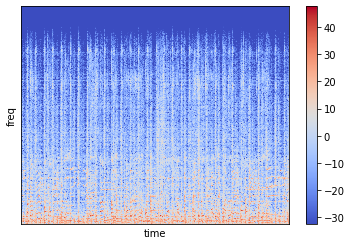

In [24]:
n_fft=2048      #frame size
hop_length=512  #strides while shifting in fft

stft=librosa.core.stft(signal,hop_length=hop_length,n_fft=n_fft)
spectrogram=np.abs(stft)
spectrogram=librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(spectrogram,sr=sr,hop_length=hop_length)
plt.xlabel('time')
plt.ylabel('freq')
plt.colorbar()

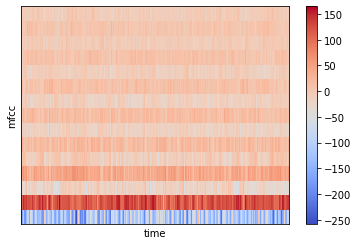

In [26]:
#MFCC
mfcc=librosa.feature.mfcc(signal,n_fft=n_fft,hop_length=hop_length,n_mfcc=n_mfcc)
librosa.display.specshow(mfcc,sr=sr,hop_length=hop_length)
plt.xlabel('time')
plt.ylabel('mfcc')
plt.colorbar()

In [15]:
def save_mfcc(data_path,json_path,n_mfcc=n_mfcc,hop_length=hop_length,n_fft=n_fft,num_segments=num_segment,c=0):

  for i,name in enumerate(os.listdir(data_path)):
        
    if name=='jazz':
        continue

    print('Processing',name)

    
    for f in os.listdir(os.path.join(data_path,name)):
      signal,sr=librosa.load(os.path.join(os.path.join(data_path,name),f),sr=SAMPLE_RATE)

      for j in range(num_segments):
        start=j*sample_per_segment
        end=start+sample_per_segment

        mfcc=librosa.feature.mfcc(signal[start:end],sr=sr,n_fft=n_fft,hop_length=hop_length,n_mfcc=n_mfcc)
#         mfcc=sklearn.preprocessing.scale(mfcc,axis=-1)
        # mfcc=librosa.power_to_db(mfcc**2,ref=np.max)
        mfcc=mfcc.T
      
        if len(mfcc)==expected_mfcc_vector_per_segment:
          data={}
          data['labels']=i
          data['mfcc']=mfcc.tolist()
          with open(os.path.join(json_path,'data_'+str(c)+'.json'),'w') as fp:
            json.dump(data,fp,indent=4)
          c=c+1    


In [17]:
save_mfcc('/content/drive/My Drive/audio classification/Data/genres_original','/content/drive/My Drive/audio classification/json_files')

Processing blues
Processing classical
Processing country
Processing disco
Processing hiphop
Processing metal
Processing pop
Processing reggae
Processing rock


In [18]:
train_path='/content/drive/My Drive/audio classification/json_files'
val_path='/content/drive/My Drive/audio classification/val'

In [19]:
val_size=int(0.15*len(os.listdir(train_path)))

for i in range(val_size):
  rand=np.random.choice(os.listdir(train_path))
  shutil.move(os.path.join(train_path,rand),'/content/drive/My Drive/audio classification/val/'+rand)

In [20]:
x_train=[]
y_train=[]
for f in tqdm(os.listdir(train_path)):
  with open(os.path.join(train_path,f),'r') as fp:
    data=json.load(fp)
  img=np.array(data['mfcc'])
  a=np.zeros((9,))
  a[data['labels']]=1
  y_train.append(a)
  img=img[...,np.newaxis]
  x_train.append(img)
x_train=np.array(x_train)
y_train=np.array(y_train)

100%|██████████| 4589/4589 [01:58<00:00, 38.71it/s]


In [21]:
x_test=[]
y_test=[]
for f in tqdm(os.listdir(val_path)):
  with open(os.path.join(val_path,f),'r') as fp:
    data=json.load(fp)
  img=np.array(data['mfcc'])
  a=np.zeros((9,))
  a[data['labels']]=1
  y_test.append(a)
  img=img[...,np.newaxis]
  x_test.append(img)
x_test=np.array(x_test)
y_test=np.array(y_test)

100%|██████████| 809/809 [00:20<00:00, 39.14it/s]


In [22]:
np.save('/content/drive/My Drive/audio classification/x_train.npy',x_train)
np.save('/content/drive/My Drive/audio classification/y_train.npy',y_train)
np.save('/content/drive/My Drive/audio classification/x_test.npy',x_test)
np.save('/content/drive/My Drive/audio classification/y_test.npy',y_test)

In [6]:
x_train=np.load('/content/drive/My Drive/audio classification/x_train.npy')
y_train=np.load('/content/drive/My Drive/audio classification/y_train.npy')
x_test=np.load('/content/drive/My Drive/audio classification/x_test.npy')
y_test=np.load('/content/drive/My Drive/audio classification/y_test.npy')

In [11]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32,3,activation='relu',input_shape=[x_train.shape[1],x_train.shape[2],1]))
model.add(tf.keras.layers.MaxPool2D(3,(2,2),padding='same'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(32,3,activation='relu'))
model.add(tf.keras.layers.MaxPool2D(3,(2,2),padding='same'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(32,2,activation='relu'))
model.add(tf.keras.layers.MaxPool2D(3,padding='same'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(9,activation='softmax'))

model.compile('adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 214, 13, 32)       320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 107, 7, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 107, 7, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 105, 5, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 53, 3, 32)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 53, 3, 32)         128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 2, 32)        

In [10]:
early=tf.keras.callbacks.EarlyStopping(patience=4)
reducelr=tf.keras.callbacks.ReduceLROnPlateau(patience=5)

In [12]:
model.fit(x_train,y_train,batch_size=16,epochs=100,validation_data=(x_test,y_test),validation_batch_size=8,callbacks=[early,reducelr])

Epoch 1/100
287/287 [==============================] - 2s 5ms/step - loss: 1.8710 - accuracy: 0.3713 - val_loss: 1.1929 - val_accuracy: 0.5451
Epoch 2/100
287/287 [==============================] - 1s 5ms/step - loss: 1.3714 - accuracy: 0.5032 - val_loss: 1.0480 - val_accuracy: 0.5921
Epoch 3/100
287/287 [==============================] - 1s 5ms/step - loss: 1.1846 - accuracy: 0.5561 - val_loss: 0.9311 - val_accuracy: 0.6625
Epoch 4/100
287/287 [==============================] - 1s 4ms/step - loss: 1.0544 - accuracy: 0.6208 - val_loss: 0.8956 - val_accuracy: 0.6737
Epoch 5/100
287/287 [==============================] - 1s 5ms/step - loss: 0.9870 - accuracy: 0.6404 - val_loss: 0.8791 - val_accuracy: 0.6737
Epoch 6/100
287/287 [==============================] - 1s 5ms/step - loss: 0.9263 - accuracy: 0.6635 - val_loss: 0.7408 - val_accuracy: 0.7441
Epoch 7/100
287/287 [==============================] - 1s 5ms/step - loss: 0.8711 - accuracy: 0.6890 - val_loss: 0.8028 - val_accuracy: 0.7108